# Imports 

Based on kernel
https://www.kaggle.com/ekhtiar/finding-pneumo-part-1-eda-and-unet 

In [6]:
import torch # base
import numpy as np
from pathlib import Path # look in folders
import pandas as pd
import pydicom # open dicom images
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches as patches

import pytorch_tools as pt # core functionality
import utils # competition specific functions
# Some notebooks magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
## Initial setup
# !pip install kaggle
# !kaggle datasets download -d jesperdramsch/siim-acr-pneumothorax-segmentation-data

In [10]:
# Data
data = Path("./data")
train_rle_path = data / "train-rle.csv"
train_rle_filtered_path = data / "train_rle_filtered.csv"
train_data_folder = data / "dicom-images-train"
test_data_folder = data / "dicom-images-test"
train_files_path = [x.as_posix() for x in sorted(train_data_folder.glob("./*/*/*"))]
test_files_path = [x.as_posix() for x in sorted(test_data_folder.glob("./*/*/*"))]
print(f"Train dataset length {len(train_files_path)}, test dataset length {len(test_files_path)}")

Train dataset length 10712, test dataset length 1377


In [11]:
# load rles
rles_df = pd.read_csv(train_rle_path)
# the second column has a space at the start, so manually giving column name
rles_df.columns = ['ImageId', 'EncodedPixels']

In [13]:
# parse train DICOM dataset
train_metadata_df = pd.DataFrame()
train_metadata_list = []
for file_path in tqdm(train_files_path):
    dicom_data = pydicom.dcmread(file_path)
    train_metadata = utils.dicom_to_dict(dicom_data, file_path, rles_df)
    train_metadata_list.append(train_metadata)
train_metadata_df = pd.DataFrame(train_metadata_list)

test_metadata_list = []
for file_path in tqdm(test_files_path):
    dicom_data = pydicom.dcmread(file_path)
    test_metadata = utils.dicom_to_dict(dicom_data, file_path, rles_df, encoded_pixels=False)
    test_metadata_list.append(test_metadata)
test_metadata_df = pd.DataFrame(test_metadata_list)

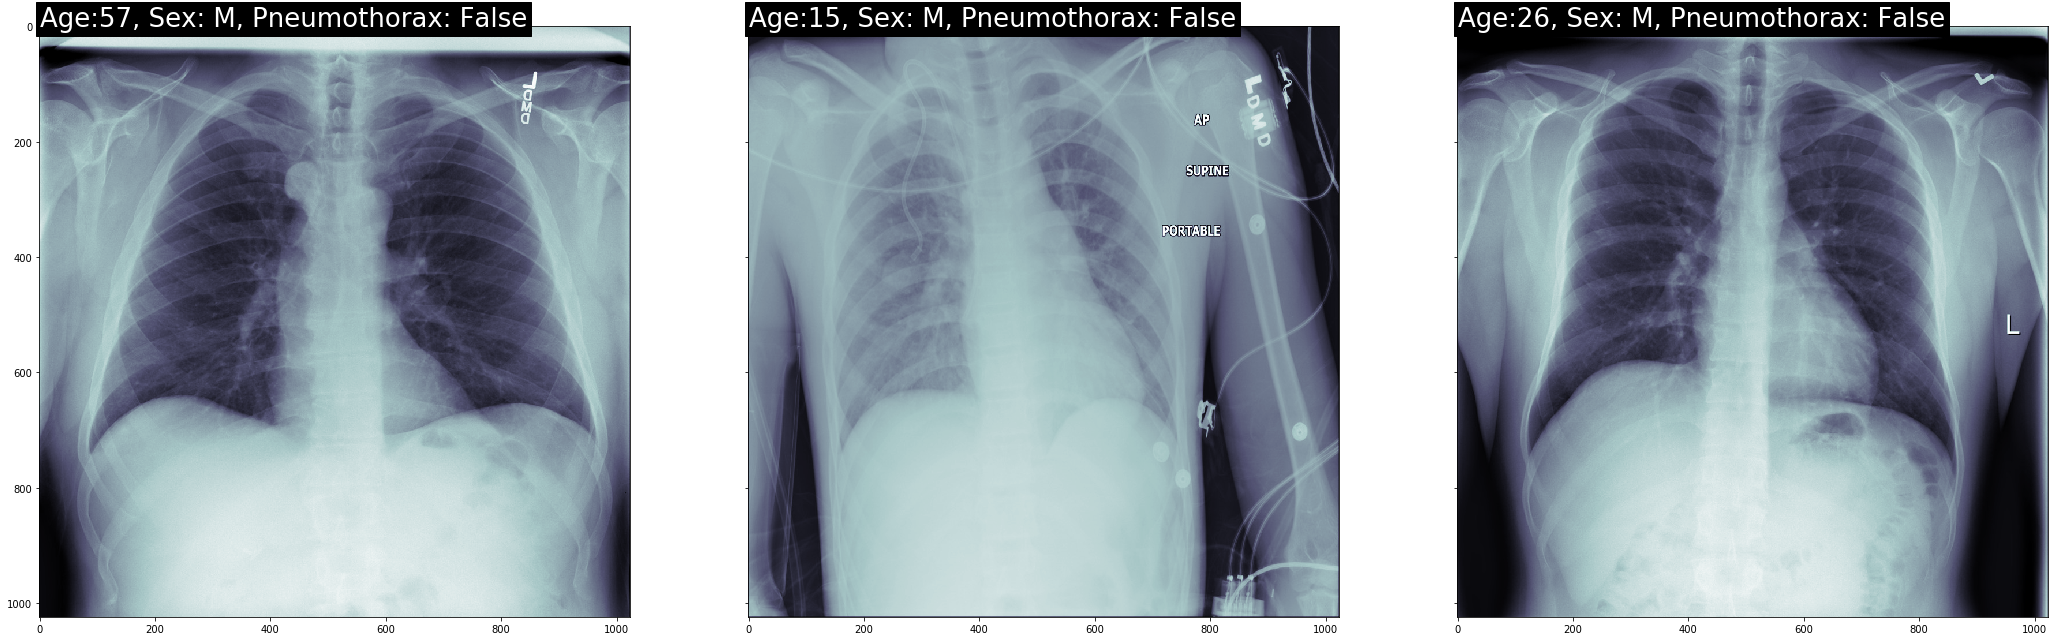

In [14]:
num_img = 3
subplot_count = 0
fig, ax = plt.subplots(nrows=1, sharey=True, ncols=num_img, figsize=(num_img*12,12))
for index, row in train_metadata_df.sample(n=num_img).iterrows():
    dataset = pydicom.dcmread(row['file_path'])
    ax[subplot_count].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    # label the x-ray with information about the patient
    ax[subplot_count].text(0,0,'Age:{}, Sex: {}, Pneumothorax: {}'.format(row['patient_age'],row['patient_sex'],row['has_pneumothorax']),
                           size=26,color='white', backgroundcolor='black')
    subplot_count += 1

image id: 1.2.276.0.7230010.3.1.4.8323329.3611.1517875178.670999
201


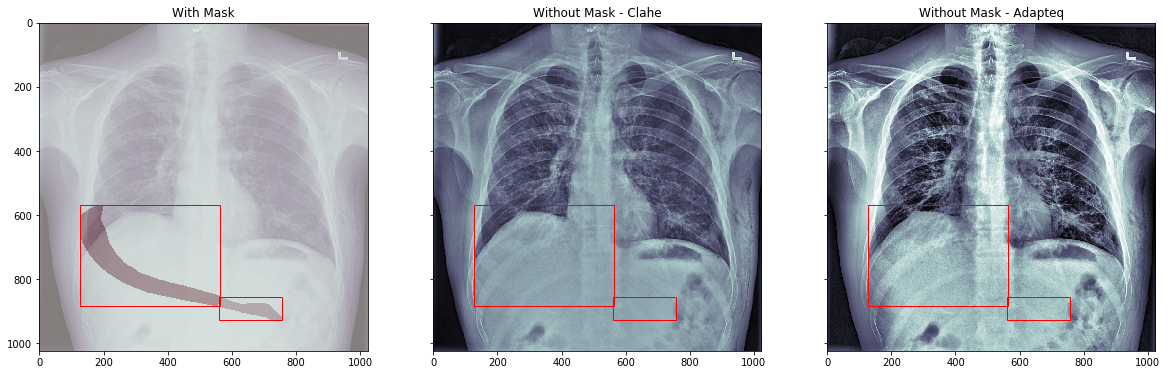

In [29]:
# lets take 3 random samples of x-rays with 
train_metadata_sample = train_metadata_df[train_metadata_df['has_pneumothorax']==1].sample(n=1)
# plot ten xrays with and without mask
for index, row in train_metadata_sample.iterrows():
    file_path = row['file_path']
    mask_encoded_list = row['encoded_pixels_list']
    print('image id: ' + row['id'])
    utils.plot_with_mask_and_bbox(file_path, mask_encoded_list)

In [ ]:
train_metadata_sample = train_metadata_df[train_metadata_df['has_pneumothorax']==1].sample(n=1)
index, row = next(train_metadata_sample.iterrows())
mask_encoded_list = row['encoded_pixels_list']